# **# Report: Restaurant CTR Optimization Model**

**Name:** Panupong Leelaratpaiboon

**Date**: 2026-02-03

**Environment:** Python 3 (Google Colab)

เพื่อให้ผลลัพธ์สามารถทำซ้ำได้ เราจะกำหนดค่า Seed และระบุ Library ที่สำคัญ

In [76]:
# Environment Setup & Reproducibility

In [77]:
# Import Libraries

In [78]:
import pandas as pd

In [79]:
import numpy as np

In [80]:
import seaborn as sns

In [81]:
import matplotlib.pyplot as plt

In [82]:
# Import Models & Metrics

In [83]:
# เลือกใช้ RandomForest เพราะสามารถใช้งานได้ง่าย และช่วยดูได้ว่า feature ไหนมีผลต่อการคลิกมากกว่ากัน

In [84]:
from sklearn.ensemble import RandomForestClassifier

In [85]:
# ใช้ classification_report เพื่อดู precision และ recall ของคลาส click ซึ่งมีสัดส่วนต่อ

In [86]:
from sklearn.metrics import classification_report

In [87]:
# ตั้ง random seed เพื่อให้ผลลัพธ์จากการรันโมเดลสามารถทำซ้ำได้

In [88]:
np.random.seed(42)
SEED = 42

## Objective & Hypothesis

**Objective:**

สร้าง Ranking Model เพื่อทำนายความน่าจะเป็นที่ User จะคลิกร้านอาหาร เพื่อนำไปจัดเรียงผลการค้นหาให้ดียิ่งขึ้น
(โมเดลนี้ใช้ทำนายความน่าจะเป็นที่ร้านจะถูกคลิก เพื่อนำไปจัดอันดับร้านใน search result)

**Hypothesis (สมมติฐาน):**


*   **Distance:** ยิ่งร้านอยู่ใกล้ User ยิ่งมีโอกาสถูกคลิกสูง

*   **Relevance:** ถ้าร้านมีชื่อตรงกับคำที่ค้นหา (`is_match`) จะมีโอกาสถูกคลิกสูงมาก

## Problem Statement


โมเดลนี้ถูกออกแบบมาเพื่อทำนายโอกาสที่ผู้ใช้จะคลิกร้านอาหารแต่ละร้าน  
โดยนำคะแนนที่ได้ไปใช้จัดเรียงลำดับร้านในหน้า search result  
เพื่อให้ร้านที่มีโอกาสถูกคลิกสูง แสดงอยู่ด้านบน

In [89]:
# Load Dataset

In [90]:
df_imp = pd.read_csv('/content/Data/impression_log_masked.csv')

In [91]:
df_click = pd.read_csv('/content/Data/click_log_masked.csv')

In [92]:
df_user = pd.read_csv('/content/Data/user_data_masked.csv')

In [93]:
df_rest = pd.read_csv('/content/Data/restaurant_data_masked.csv')

In [94]:
# พิมพ์เช็กขนาดข้อมูล

In [95]:
print(f"Impression Data: {df_imp.shape}")

Impression Data: (174410, 11)


In [96]:
print(f"Click Data: {df_click.shape}")

Click Data: (23016, 3)


In [97]:
print(f"User Data: {df_user.shape}")

User Data: (6000, 7)


In [98]:
print(f"Restaurant Data: {df_rest.shape}")

Restaurant Data: (3466, 10)


## Data Cleaning & Handling

จากการตรวจสอบข้อมูล พบปัญหาและจัดการดังนี้:

* **Missing Values:** ค่าว่างเกิดจากการ Left Join (ไม่มี Click Log) จึงแทนค่าด้วย 0 เพื่อระบุสถานะว่า **"ไม่ได้คลิก"**

* **Imbalanced Data:** ข้อมูลการคลิกมีน้อยมาก (~10%) ซึ่งจะส่งผลต่อการวัดผล เราจึงวางแผนใช้ `class_weight` ในขั้นตอน Modeling

In [99]:
df_click.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23016 entries, 0 to 23015
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Unnamed: 0     23016 non-null  int64
 1   impression_id  23016 non-null  int64
 2   click_flag     23016 non-null  int64
dtypes: int64(3)
memory usage: 539.6 KB


In [100]:
df_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174410 entries, 0 to 174409
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Unnamed: 0         174410 non-null  int64 
 1   search_session_id  174410 non-null  int64 
 2   impression_id      174410 non-null  int64 
 3   user_id            174410 non-null  int64 
 4   rtt_id             174410 non-null  int64 
 5   itemindex          174410 non-null  int64 
 6   searchkeyword      174235 non-null  object
 7   platform           174410 non-null  object
 8   hour               174410 non-null  int64 
 9   date               174410 non-null  int64 
 10  hashed_province    174410 non-null  object
dtypes: int64(8), object(3)
memory usage: 14.6+ MB


In [101]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    6000 non-null   int64  
 1   user_id                       6000 non-null   int64  
 2   lat_noised                    6000 non-null   float64
 3   lng_noised                    6000 non-null   float64
 4   user_avg_restaurant_rating    4976 non-null   float64
 5   top_restaurant_main_category  5854 non-null   object 
 6   avg_straight_distance         5839 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 328.3+ KB


In [102]:
df_rest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3466 entries, 0 to 3465
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 3466 non-null   int64  
 1   id                         3466 non-null   int64  
 2   chain_name                 3421 non-null   object 
 3   latitude                   3466 non-null   float64
 4   longitude                  3466 non-null   float64
 5   business_main_category     3457 non-null   object 
 6   business_price_range       3466 non-null   object 
 7   total_available_menu       3452 non-null   float64
 8   avg_food_price             3452 non-null   float64
 9   restaurant_past_14day_ctr  3326 non-null   float64
dtypes: float64(5), int64(2), object(3)
memory usage: 270.9+ KB


In [103]:
df_train = df_imp.merge(df_click[['impression_id', 'click_flag']], on='impression_id', how='left')

In [104]:
df_train = df_train.merge(df_user, on='user_id', how='left')

In [105]:
df_train = df_train.merge(df_rest, left_on='rtt_id', right_on='id', how='left')



*   หลังจากรวมข้อมูลจาก impression, click, user และ restaurant เข้าด้วยกัน พบว่าบาง feature มีค่า missing อยู่บ้าง
สำหรับ feature เชิงตัวเลข ใช้การเติมค่ากลาง (median หรือ mean) เพื่อไม่ให้ข้อมูลหายกระทบกับการเทรนโมเดล
เลือกวิธีที่เรียบง่าย เนื่องจากสัดส่วนข้อมูลที่หายไม่ได้สูง และต้องการหลีกเลี่ยงการเพิ่มความซับซ้อนเกินจำเป็น

*   สำหรับข้อมูลตัวเลขที่กระจายไม่สม่ำเสมอ เลือกเติมค่ากลางด้วย median เพื่อลดผลกระทบจากค่าที่ผิดปกติ
ส่วน feature ที่เป็นอัตราส่วนอย่าง CTR ใช้ค่าเฉลี่ย (mean) แทน



In [106]:
median_price = df_train['avg_food_price'].median()
df_train['avg_food_price'] = df_train['avg_food_price'].fillna(median_price)

In [107]:
median_menu = df_train['total_available_menu'].median()
df_train['total_available_menu'] = df_train['total_available_menu'].fillna(median_menu)

In [108]:
mean_ctr = df_train['restaurant_past_14day_ctr'].mean()
df_train['restaurant_past_14day_ctr'] = df_train['restaurant_past_14day_ctr'].fillna(mean_ctr)

In [109]:
price_map = {
    'ไม่มีข้อมูล': 0,
    'Less than 100': 1,
    '101 - 250 THB': 2,
    '251 - 500 THB': 3,
    '501 - 1000 THB': 4,
    'Over 1000 THB': 5,
}


In [110]:
df_train['price_level'] = df_train['business_price_range'].map(price_map)

In [111]:
df_train['price_level'] = df_train['price_level'].fillna(0)

In [112]:
df_train['click_flag'] = df_train['click_flag'].fillna(0)

click_flag บางแถวมีค่า missing ซึ่งสามารถตีความได้ว่าไม่มีการคลิกเกิดขึ้น จึงเติมค่า 0 เพื่อให้ label เป็นข้อมูลแบบ binary และพร้อมนำไปใช้ในการฝึกโมเดล

## Feature Engineering

ในขั้นตอนนี้ได้สร้าง feature เพิ่มจากข้อมูลเดิม เพื่อช่วยให้โมเดลเข้าใจพฤติกรรมผู้ใช้มากขึ้น
โดยเน้น feature ที่สะท้อนความใกล้ของร้าน และความสอดคล้องกับความสนใจของผู้ใช้




* **`distance_km`**: คำนวณจาก Lat/Long เพราะระยะทางเป็นปัจจัยเชิงกายภาพที่สำคัญที่สุด
* **`is_match`**: ตรวจสอบว่าชื่อร้านตรงกับคำที่ค้นหาหรือไม่ เพื่อระบุว่าผู้ใช้มีความต้องการเจาะจงที่ร้านนี้ ซึ่งสัมพันธ์กับโอกาสในการคลิกที่สูงขึ้น (**`is_match`** ใช้แทน keyword relevancy ในระดับพื้นฐาน)

จากการลองใช้ feature หลายตัว พบว่าบาง feature ไม่ได้ช่วยแยก click ได้ชัดเจน จึงตัดออกเพื่อให้โมเดลเรียบง่ายขึ้น

In [113]:
def haversine_np(lat1, lon1, lat2, lon2):
    R = 6371  # รัศมีโลก (km)
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

In [114]:
df_train['distance_km'] = haversine_np(
    df_train['lat_noised'],
    df_train['lng_noised'],
    df_train['latitude'],
    df_train['longitude']
)

สร้าง feature ระยะทางระหว่างผู้ใช้กับร้านอาหาร
และตรวจสอบว่าชื่อร้านตรงกับคำค้นหาหรือไม่ เพื่อช่วยให้โมเดลแยกพฤติกรรมการคลิกได้ดีขึ้น

In [115]:
df_train['searchkeyword'] = df_train['searchkeyword'].fillna('').astype(str).str.lower()

In [116]:
df_train['chain_name'] = df_train['chain_name'].fillna('').astype(str).str.lower()

In [117]:
df_train['is_match'] = df_train.apply(
    lambda x: 1 if x['searchkeyword'] in x['chain_name'] else 0,
    axis=1
)

ปรับ `searchkeyword` และ `chain_name` ให้อยู่ในรูปแบบตัวพิมพ์เล็กและจัดการค่า missing เพื่อให้สามารถเปรียบเทียบข้อความได้อย่างถูกต้อง  
จากนั้นสร้าง feature `is_match` เพื่อตรวจสอบว่าคำค้นหาของผู้ใช้ตรงกับชื่อร้านหรือไม่  
เมื่อวิเคราะห์เบื้องต้น พบว่ากลุ่มที่ `is_match = 1` มีอัตราการคลิกสูงกว่า จึงนำ feature นี้ไปใช้ในการฝึกโมเดล

## Modeling & Evaluation Strategy



*   แบ่งข้อมูล train และ validation ตาม `search_session_id` เพื่อป้องกันไม่ให้ข้อมูลจาก session เดียวกันไปอยู่ทั้งสองฝั่ง  
ใช้สัดส่วนประมาณ 80:20 สำหรับการประเมินผลโมเดล



**Model Selection:**
เลือกใช้ Random Forest เนื่องจากสามารถจับความสัมพันธ์ที่ไม่เป็นเส้นตรงระหว่าง feature ได้ และเหมาะกับข้อมูลเชิงตาราง

**Evaluation Metrics:**
เลือกใช้ Recall เพราะข้อมูลไม่สมดุล และต้องการลดโอกาสพลาดลูกค้าที่มีแนวโน้มจะคลิก

**Reasoning (เหตุผล):**
เนื่องจากคนคลิกจริงมีน้อยมาก (~10%) ถ้าเราดูแต่ค่า Accuracy โมเดลอาจจะทายว่า "ไม่คลิก" ทั้งหมดก็ได้คะแนนสูงแล้ว ซึ่งเป็นการหลอกตา
เป้าหมายจริงๆ ของเราคือ **"ต้องหาลูกค้าที่จะคลิกให้เจอ"** (ห้ามพลาดลูกค้าตัวจริง) ดังนั้นค่า Recall จึงเป็นตัวบอกว่าเราเก่งแค่ไหนในการหาลูกค้าครับ

In [118]:
unique_sessions = df_train['search_session_id'].unique()

In [119]:
np.random.shuffle(unique_sessions)

In [120]:
split_point = int(len(unique_sessions) * 0.8)

In [121]:
train_session_ids = unique_sessions[:split_point]
val_session_ids = unique_sessions[split_point:]

In [122]:
df_train_set = df_train[df_train['search_session_id'].isin(train_session_ids)]
df_val_set = df_train[df_train['search_session_id'].isin(val_session_ids)]

In [123]:
print(f"Train rows: {len(df_train_set)}")
print(f"Val rows: {len(df_val_set)}")

Train rows: 138881
Val rows: 35529


In [124]:
features_cols = ['distance_km', 'price_level', 'is_match']

In [125]:
X_train = df_train_set[features_cols]

In [126]:
y_train = df_train_set['click_flag']

In [127]:
X_val = df_val_set[features_cols]

In [128]:
y_val = df_val_set['click_flag']

In [129]:
my_model = RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced')

In [130]:
my_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [131]:
importance = pd.Series(my_model.feature_importances_, index=features_cols)

In [132]:
print(importance.sort_values(ascending=False))

distance_km    0.934639
is_match       0.063120
price_level    0.002242
dtype: float64


จาก feature importance พบว่า `distance_km` มีผลต่อการตัดสินใจคลิกมากที่สุด รองลงมาคือ `is_match`  
สอดคล้องกับพฤติกรรมผู้ใช้ที่มักเลือกดูร้านใกล้ตัว และร้านที่ตรงกับสิ่งที่ค้นหา

พบว่า is_match = 1 มีสัดส่วนค่อนข้างน้อยเมื่อเทียบกับทั้งหมด
แต่ยังเพียงพอให้โมเดลเรียนรู้ได้

In [133]:
accuracy = my_model.score(X_val, y_val)

In [134]:
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 76.02%


รายงานค่า Accuracy เพื่อใช้อ้างอิงภาพรวม
เนื่องจากข้อมูลส่วนใหญ่เป็นกรณีที่ไม่คลิก ทำให้การดูแค่ Accuracy อาจไม่สะท้อนผลจริง

In [135]:
prediction = my_model.predict(X_val)

In [136]:
print(classification_report(y_val, prediction))

              precision    recall  f1-score   support

         0.0       0.88      0.84      0.86     30862
         1.0       0.18      0.24      0.21      4667

    accuracy                           0.76     35529
   macro avg       0.53      0.54      0.53     35529
weighted avg       0.79      0.76      0.77     35529



ผลการประเมินพบว่าโมเดลสามารถจับกลุ่มที่ไม่คลิกได้ค่อนข้างดี  
การทำนายว่าผู้ใช้จะคลิกจริงเป็นเรื่องยาก เพราะจำนวนการคลิกมีน้อยกว่าไม่คลิกมาก

In [137]:
feat_importances = pd.Series(my_model.feature_importances_, index=X_train.columns)

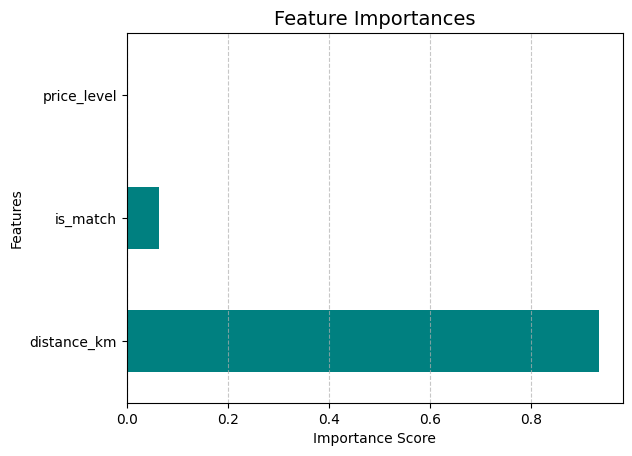

In [138]:
feat_importances.nlargest(10).plot(kind='barh', color='teal')
plt.title("Feature Importances", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

จาก feature importance พบว่า `distance_km` มีอิทธิพลต่อการตัดสินใจคลิกมากที่สุด  
สะท้อนว่าผู้ใช้มีแนวโน้มคลิกร้านที่อยู่ใกล้ตัวมากกว่าร้านที่อยู่ไกล

## Conclusion & Discussion

**Real-world Deployment (การนำไปใช้จริง):**
โมเดลนี้สามารถนำไปใช้จัดเรียงร้านอาหารในหน้า search result
โดยให้ร้านที่มีโอกาสถูกคลิกสูงแสดงก่อน

**Business Impact:**
ช่วยเพิ่มโอกาสที่ผู้ใช้จะเห็นร้านที่ตรงความต้องการมากขึ้น
ซึ่งอาจนำไปสู่จำนวนคลิกที่เพิ่มขึ้น

**Supplemental Data (ข้อมูลเสริมที่อยากได้):**
หากมีข้อมูลพฤติกรรมผู้ใช้เพิ่มเติม เช่น ร้านที่เคยสั่ง หรือช่วงเวลาที่สั่งบ่อย
โมเดลอาจทำนายผลได้แม่นยำขึ้น